### 1. Dealing with missing data

In [1]:
from pandas import Series, DataFrame
import pandas as pd
from numpy.random import randn
import numpy as np
from collections import Counter
import time
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train = pd.read_table('round1_train.txt',sep = ' ')
test_a = pd.read_table('round1_testa.txt',sep = ' ')
test_b = pd.read_table('round1_testb.txt',sep = ' ')
test = pd.concat([test_a,test_b]) # combine a,b test set
print(train.shape,test.shape)
print(list(train.columns))

(478138, 27) (61259, 26)
['instance_id', 'item_id', 'item_category_list', 'item_property_list', 'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level', 'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id', 'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id', 'context_timestamp', 'context_page_id', 'predict_category_property', 'shop_id', 'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level', 'shop_score_service', 'shop_score_delivery', 'shop_score_description', 'is_trade']


In [3]:
# drop duplicate instances in train and test
train.drop_duplicates(inplace = True)
test.drop_duplicates(inplace = True)

In [4]:
print('positive instances num: ',sum(train['is_trade']))
print('negative instances num: ', train.shape[0] - sum(train['is_trade']))

positive instances num:  8994
negative instances num:  469117


In [5]:
# how many missing data in each feature?

# item_brand_id: 473  
# item_city_id: 277  
# item_sales_level: 913  
# user_gender_id: 12902 
# user_age_level: 964   
# user_star_level: 964  
# user_occupation_id: 964  
# shop_review_positive_rate: 7   
# shop_score_service 59
# shop_score_delivery 59
# shop_score_description 59

for feature in list(train):
    missing_num = (train[feature] == -1).sum()
    if missing_num > 0:
        print(feature, missing_num)

item_brand_id 473
item_city_id 277
item_sales_level 913
user_gender_id 12902
user_age_level 964
user_occupation_id 964
user_star_level 964
shop_review_positive_rate 7
shop_score_service 59
shop_score_delivery 59
shop_score_description 59


In [6]:
# fill id with the most common one or two
def filling_id(df,feature,missing_num):
    cc = Counter(df[feature])
    common = cc.most_common(2)
    # intutionly choose 5
    if common[0][1]/common[1][1] < 5: 
        total = common[0][1] + common[1][1]
        p = [common[0][1]/total, common[1][1]/total]
        replace = np.random.choice([common[0][0], common[0][1]],missing_num,p)
        df.loc[df[feature] == -1, feature] = replace
    else:
        df.loc[df[feature] == -1, feature] = common[0][0]
    return df

train= filling_id(train, 'item_brand_id', 473)
train = filling_id(train,'item_city_id', 277)
train = filling_id(train,'user_gender_id',12902)
train = filling_id(train,'user_occupation_id',964)

In [7]:
# filling level with the most common six values
def filling_level(df,feature,missing_num):
    cc = Counter(df[feature])
    # intutionly choose 6
    common = cc.most_common(6)
    total = 0
    p = []
    replace_list = []
    for i in common:
        total += i[1]
    for i in common:
        p.append(i[1]/total)
        replace_list.append(i[0])
    replace = np.random.choice(replace_list,missing_num,p)
    df.loc[df[feature] == -1, feature] = replace
    return df

train = filling_level(train,'item_sales_level', 913)
train = filling_level(train,'user_age_level', 964)
train = filling_level(train, 'user_star_level', 964)

In [8]:
# replace missing data in these three columns with average
items = ['shop_score_service', 'shop_score_delivery', 'shop_score_description']
shop_service_mean = train.loc[train[items[0]] != -1, items[0]].mean()
train.loc[train[items[0]] == -1, items[0]] = shop_service_mean
shop_delivery_mean = train.loc[train[items[1]] != -1, items[1]].mean()
train.loc[train[items[1]] == -1, items[1]] = shop_delivery_mean
shop_description_mean = train.loc[train[items[2]] != -1, items[2]].mean()
train.loc[train[items[2]] == -1, items[2]] = shop_description_mean

In [9]:
# filling shop_review_positive_rate
cc = Counter(train['shop_review_positive_rate'])
print(cc.most_common(2))
train.loc[train['shop_review_positive_rate'] == -1, 'shop_review_positive_rate'] = 1

[(1.0, 265918), (0.9970402457701614, 1852)]


In [10]:
train.head()


,instance_id,item_id,item_category_list,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,...,context_page_id,predict_category_property,shop_id,shop_review_num_level,shop_review_positive_rate,shop_star_level,shop_score_service,shop_score_delivery,shop_score_description,is_trade
0,108641074714126964,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,...,4006,5799347067982556520:-1;509660095530134768:-1;5...,6765930309048922341,4,1.0,5002,1.0,1.0,1.0,0
1,5754713551599725161,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,...,4001,5799347067982556520:9172976955054793469;790838...,6765930309048922341,4,1.0,5002,1.0,1.0,1.0,0
2,842679481291040981,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,...,4001,5799347067982556520:5131280576272319091;725801...,6765930309048922341,4,1.0,5002,1.0,1.0,1.0,0
3,937088850059189027,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,...,4016,509660095530134768:-1;5799347067982556520:-1;7...,6765930309048922341,4,1.0,5002,1.0,1.0,1.0,0
4,7975697065017708072,3412720377098676069,7908382889764677758;5799347067982556520,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,...,4001,5799347067982556520:9172976955054793469;790838...,6765930309048922341,4,1.0,5002,1.0,1.0,1.0,0


### 2. Deal with timestamp

In [11]:
# convert timestamp to date
def timestamp_datetime(stamp):
    struct_time = time.localtime(stamp)
    date_time = time.strftime('%Y-%M-%d %H:%M:%S', struct_time)
    return date_time

def convert_date_time(df):
    df['datetime'] = df.context_timestamp.apply(timestamp_datetime)
    df['day'] = df.datetime.apply(lambda x: int(x[8:10]))
    df['hour'] = df.datetime.apply(lambda x: int(x[11:13]))
    df['time'] = df.datetime.apply(lambda x: x[11:])
    return df

train = convert_date_time(train)
test = convert_date_time(test)

In [12]:
# how many days in the dataset?
# how many samples in each day?
cc_train = Counter(train['day'])
cc_test = Counter(test['day'])

In [13]:
# what's conversion rate in each day? Is there any special promotion day?
days = cc_train.keys()
conv_rates = []
for day in days:
    conv_rate = train[train['day'] == day]['is_trade'].sum() / len(train[train['day'] == day])
    conv_rates.append(conv_rate)
print(conv_rates)

[0.02459727983023054, 0.01895510632711998, 0.019108745869762273, 0.01879891119428377, 0.020147202016152128, 0.019324731560314813, 0.016210461796538542, 0.016020155923179312]


In [14]:
# convert hour into midnight(0/24-7), morning(7-13), afternoon(13-19), night(19-24).
def convert_to_timeslot(data):
    data['is_midnight'], data['is_morning'], data['is_afternoon'],data['is_night'] = -1, -1, -1, -1
    data['is_midnight'] = (data['hour'] <= 7).astype('int')
    data['is_morning'] = ((data['hour'] > 7) & (data['hour'] <= 13)).astype('int')
    data['is_afternoon'] = ((data['hour'] > 13) & (data['hour'] <= 19)).astype('int')
    data['is_night'] = (data['hour'] > 19).astype('int')
    return data

train = convert_to_timeslot(train)
test = convert_to_timeslot(test)


### 3. Dealing with categorical feature  
#### item_category_list & item_property_list & predict_category_property    
 `['item_category_list']`: lists of the item's properties, of type String. The format is combined as "category_0; category_1; category_2", starting from the root category (the high-level category) to the lead category (the most detailed category).       
`['item_property_list']`: lists of item's properties, of type String. The format is combined as "property_0; property_1; property_2". Each property has no affiliation with the others.     
`['predict_category_property']`: lists of the predicted categories and properties, of type String. The format is combined as "category A: property_A_1, property_A_2, property_A_3; catgory B: property_B_1, property_B_2, property_B_3"

In [16]:
# Since we observe that the root category is always the same in our dataset (7908382889764677758), 
# and there are two categories in the dataset, we only consider the second one 
train['item_category'] = train['item_category_list'].apply(lambda x: str(x).split(';')[1])
test['item_category'] = test['item_category_list'].apply(lambda x: str(x).split(';')[1])

In [17]:
# item_category_list & item_property_list & predict_category_property
def extract_pred_cate_props(data):
    # extract category and property list from predict_cate_prop_lists 
    pred_cate_prop_lists = list(data['predict_category_property'].str.split(';'))
    pred_cate_lists = []
    pred_prop_lists = []
    for pred_cate_props in pred_cate_prop_lists:
        pred_cate_list = []
        pred_prop_list = []
        
        if pred_cate_props == ['-1']:
            pred_cate_lists.append('-1')
            pred_prop_lists.append('-1')
            continue
        
        for pred_cate_prop in pred_cate_props:
            cate = pred_cate_prop.split(':')[0]
            if cate not in pred_cate_list:
                pred_cate_list.append(cate)
                
            props = pred_cate_prop.split(':')[1]
            props = props.split(',')
            for p in props:
                if p not in pred_prop_list:
                    pred_prop_list.append(p)
                    
        pred_cate_lists.append(pred_cate_list)
        pred_prop_lists.append(pred_prop_list)
    return pred_cate_lists, pred_prop_lists
    

In [18]:
def calc_cate_prop_precision_recall(data):
    cate_lists = list(data['item_category_list'].str.split(';')) 
    prop_lists = list(data['item_property_list'].str.split(';')) 
    pred_cate_lists, pred_prop_lists = extract_pred_cate_props(data)
    
    cate_precision_list = []
    cate_recall_list = []
    for pred_cate, cate in zip(pred_cate_lists, cate_lists):
        count = 0
        for i in pred_cate:
            if i in cate:
                count += 1
        cate_precision = count / len(pred_cate)
        cate_recall = count/len(cate)
        
        cate_precision_list.append(cate_precision)
        cate_recall_list.append(cate_recall)
    
    # Question: how to deal with missing data in category and property list????
    prop_precision_list = []
    prop_recall_list = []
    for pred_prop, prop in zip(pred_prop_lists, prop_lists):
        count = 0
        for i in pred_prop:
            if i in prop:
                count += 1
        prop_precision = count / len(pred_prop)
        prop_recall = count/len(prop)
        
        prop_precision_list.append(prop_precision)
        prop_recall_list.append(prop_recall)
    
    return cate_precision_list, cate_recall_list, prop_precision_list, prop_recall_list 

In [19]:
cate_precision_list, cate_recall_list, prop_precision_list, prop_recall_list = calc_cate_prop_precision_recall(train)
train['cate_precision'] = cate_precision_list
train['cate_recall'] = cate_recall_list
train['prop_precision'] = prop_precision_list
train['prop_recall'] = prop_recall_list
train.drop(['item_category_list', 'predict_category_property'],axis=1,inplace=True)

cate_precision_list, cate_recall_list, prop_precision_list, prop_recall_list = calc_cate_prop_precision_recall(test)
test['cate_precision'] = cate_precision_list
test['cate_recall'] = cate_recall_list
test['prop_precision'] = prop_precision_list
test['prop_recall'] = prop_recall_list
test.drop(['item_category_list', 'predict_category_property'],axis=1,inplace=True)

### 4. Dealing with continuous feature   
For some of continuous features, if they do not show clear linear relation with label, we may need to divide them into different section to find out the clear correlation.

`['item_price_level'], ['item_sales_level'], ['item_collected_level'], ['item_pv_level']`     
`['user_age_level'], ['user_star_level']`   
`['shop_review_num_level'], ['shop_review_positive_rate'], ['shop_star_level'], ['shop_score_service'], ['shop_score_delivery'], ['shop_score_description']`

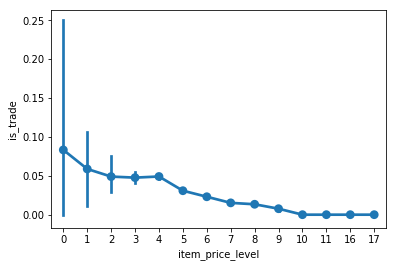

In [20]:
# item_price_level:
# we can see that is_trade decreasing with item_price_level increasing.
# the higher the price, the less trade probability

# item_sales_level:
# in general, the higher the item_sales_level, the higher trade probability

# item_collected_level: 
# in general, the higher the item_collected_level, the higher trade probability

# item_pv_level: 
# extrordinarly high in 3 level. is_trade subtly increasing with item_pv_level

sns.pointplot(x='item_price_level', y='is_trade', data=train)
#sns.pointplot(x='item_sales_level', y='is_trade', data=train)
#sns.pointplot(x='item_collected_level', y='is_trade', data=train)
#sns.pointplot(x='item_pv_level', y='is_trade', data=train)

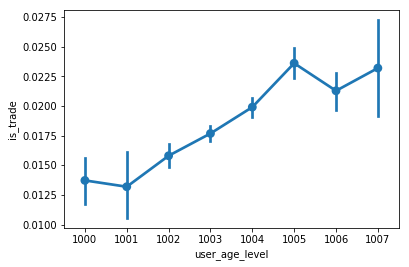

In [21]:
# user_age_level:
# is_trade increase with user_age_level increase

# user_star_level: 
# subtly increase as user_start_level increase, and extraordinarly large in 3010 
sns.pointplot(x='user_age_level', y='is_trade', data=train)
#sns.pointplot(x='user_star_level', y='is_trade', data=train)

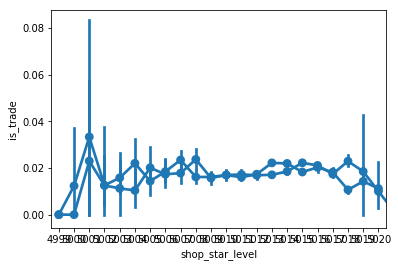

In [22]:
sns.pointplot(x='shop_review_num_level', y='is_trade', data=train)
sns.pointplot(x='shop_star_level', y='is_trade', data=train)

# the remaining four plots are too intensive, and are not discrimincative
# thus, we want to divide them into different section

# sns.pointplot(x='shop_review_positive_rate', y='is_trade', data=train)
# sns.pointplot(x='shop_score_service', y='is_trade', data=train)
# sns.pointplot(x='shop_score_delivery', y='is_trade', data=train)
# sns.pointplot(x='shop_score_description', y='is_trade', data=train)

In [23]:
train[['shop_score_description']].quantile(0.20)

shop_score_description    0.965535
Name: 0.2, dtype: float64

In [24]:
'''
def f(x):
    if x > 0.984:
        return 2
    elif x > 0.97 and x <= 0.984:
        return 1
    else:
        return 0
train['shop_score_description'] = train'shop_score_description'].apply(f)
sns.pointplot(x = 'shop_score_description', y = 'is_trade', data=train)
'''

"\ndef f(x):\n    if x > 0.984:\n        return 2\n    elif x > 0.97 and x <= 0.984:\n        return 1\n    else:\n        return 0\ntrain['shop_score_description'] = train'shop_score_description'].apply(f)\nsns.pointplot(x = 'shop_score_description', y = 'is_trade', data=train)\n"

In [25]:
train.to_csv('data/complete_train.csv', index = None)
test.to_csv('data/test.csv',index = None)

In [26]:
train.columns

Index(['instance_id', 'item_id', 'item_property_list', 'item_brand_id',
       'item_city_id', 'item_price_level', 'item_sales_level',
       'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id',
       'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'shop_id',
       'shop_review_num_level', 'shop_review_positive_rate', 'shop_star_level',
       'shop_score_service', 'shop_score_delivery', 'shop_score_description',
       'is_trade', 'datetime', 'day', 'hour', 'time', 'is_midnight',
       'is_morning', 'is_afternoon', 'is_night', 'item_category',
       'cate_precision', 'cate_recall', 'prop_precision', 'prop_recall'],
      dtype='object')

In [27]:
train.head()

,instance_id,item_id,item_property_list,item_brand_id,item_city_id,item_price_level,item_sales_level,item_collected_level,item_pv_level,user_id,...,time,is_midnight,is_morning,is_afternoon,is_night,item_category,cate_precision,cate_recall,prop_precision,prop_recall
0,108641074714126964,3412720377098676069,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,4505772604969228686,...,22:09:04,0,0,0,1,5799347067982556520,0.400000,1.0,0.0,0.000000
1,5754713551599725161,3412720377098676069,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,2692638157208937547,...,00:00:32,1,0,0,0,5799347067982556520,1.000000,1.0,0.2,0.045455
2,842679481291040981,3412720377098676069,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,5247924392014515924,...,15:04:12,0,0,1,0,5799347067982556520,0.666667,1.0,1.0,0.045455
3,937088850059189027,3412720377098676069,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,2681414445369714628,...,18:17:50,0,0,1,0,5799347067982556520,0.400000,1.0,0.0,0.000000
4,7975697065017708072,3412720377098676069,2072967855524022579;5131280576272319091;263639...,1975590437749032870,3948283326616421003,3,3,4,14,2729475788342039013,...,07:48:40,1,0,0,0,5799347067982556520,1.000000,1.0,1.0,0.045455


In [28]:
train.shape

(478111, 38)

In [29]:
test.shape

(61259, 37)